## Analysis of antibiotic resistance in the premature infant gut microbiome
### Sumayah F. Rahman 2017



### Load libraries

In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import plotly.plotly as py
import plotly.figure_factory as ff
import statsmodels
from statsmodels import sandbox
from statsmodels.sandbox import stats
from statsmodels.sandbox.stats import multicomp
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import collections
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
import warnings; warnings.simplefilter('ignore')
%load_ext rpy2.ipython
%load_ext iversions

In [831]:
%iversions

sklearn     0.18.1
seaborn     0.7.1
numpy       1.13.1
pandas      0.20.3
statsmodels  0.6.1
scipy       0.18.0

Python 3.5.2 [Sun Aug 27, 2017 14:36:14]


### Load annotation data, iRep data, and metadata

We processed over 4 terrabases (Tb) of sequence data in a metagenomics pipeline to generate the data for the below analysis. The scaffold coverage file was produced by read mapping metagenome assemblies (assembled with idba_ud) to their respective short reads sequence fastq files, using bowtie2. Scaffold-to-bin file is based on Concoct genome bins. Antibiotic resistance (Resfams) and general metabolism (KEGG) genes were annotated using hidden Markov models. Further details on how these files were produced can be found in the 'Methods' section of the associated publication. The infant metadata and sample metadata files were created by re-formatting medical data from the Magee-Women's hospital of Pittsburgh, PA.

In [775]:
%%bash

#Remove excess lines from Resfams HMMER output file so that it is parsable
sed -i -e 1,3d resfams_HMM_output.txt
head -n 104384 resfams_HMM_output.txt > resfams_HMM_output_clean.txt

In [ ]:
infant_metadata = pd.read_csv("infantMetadata_3April17.csv")
sample_metadata = pd.read_csv("sampleMetadata_3April17.csv")
project_info = pd.read_csv("project_info.csv") 
scaffold_coverage = pd.read_csv("scaffold_coverage.csv")
resfams_metadata = pd.read_csv("resfams_metadata.csv")
resfams_output = pd.read_table("resfams_HMM_output_clean.txt", delimiter=r"\s+", header=None)
KEGG_gene_annotations = pd.read_csv("genes_in_concot_bins.keggHMM.report.tab", sep="\t")
KEGG_genome_profiles = pd.read_csv("genes_in_concot_bins.module.completeness.reliable_plus_eval_1e-10.tab", sep ="\t")
scaf2bin = pd.read_table('all.stb', header=None) 
genome_taxonomy = pd.read_csv('concoct_genome_taxonomy.csv') 
iRep_info = pd.read_csv('iRep_w_metadata.csv')

### Infant Characteristics

In [843]:
def label_breastmilk(row):
    """Return 'True' if the infant received breastmilk at some point during the time period samples
    were taken, and return 'False' if the infant received formula only. """
    if row['feeding'] == 'Breast' or row['feeding'] == 'Combination':
        return(True)
    if row['feeding'] == 'Forumla':
        return(False)

def calculate_characteristics(df, category):
    """Calculate the number of infants with particular characteristics (feeding, gender, 
    maternal antibiotics, birth mode.)"""
    # Using the metadata dataframe, determine the number of infants with each characteristic
    received_breastmilk = len(df.loc[df['received_breastmilk']==True]['infant'].unique())
    male = len(df.loc[df['gender']=='M']['infant'].unique())
    received_maternal_ab = len(df.loc[df['maternal_ab']==True]['infant'].unique())
    c_section = len(df.loc[df['birth_mode']=='C-section']['infant'].unique())
    vaginal_birth = len(df.loc[df['birth_mode']=='Vaginal']['infant'].unique())
    number_samples = len(df)
    number_infants = len(df['infant'].unique())
    # Create an ordered dictionaty that represents the categories and the values for each category
    odict = collections.OrderedDict([('Samples', number_samples), 
                                     ('Infants', number_infants), 
                                     ('Male sex', male), 
                                    ('Received breastmilk', received_breastmilk), 
                                     ('Delivered by C-section', c_section),
                                     ('Maternal antibiotics', received_maternal_ab)])
    characteristics_df = pd.DataFrame(data=odict, index=category) # Convert dict to dataframe
    return(characteristics_df)

def generate_characteristic_table(sample_metadata, infant_metadata):
    """Produce table that displays the infant metadata in regard to the infants that only received
    antibiotics in the first week of life (left) and the infants that received additional antibiotics (right)."""
    all_metadata = sample_metadata.merge(infant_metadata, on='infant') # Combine sample and infant metadata
    all_metadata['received_breastmilk'] = all_metadata.apply(lambda row: label_breastmilk(row),axis=1)
    extra_abx_babies = all_metadata.loc[all_metadata['postweek_ab'] == True] # babies that received additional abx
    healthy_babies = all_metadata.loc[all_metadata['postweek_ab'] == False] # babies that only received abx in 1st week
    df = calculate_characteristis(extra_abx_babies,['Received postweek antibiotics due to disease']) 
    df2 = df.transpose()
    df2['Category'] = df2.index
    df3 = calculate_characteristis(healthy_babies, ['No antibiotics after the first week of life'])
    df4 = df3.transpose()
    df4['Category'] = df4.index
    df5 = df2.merge(df4, on='Category') # merge healthy-infant-df with extra-antibiotics-infant df
    df5 = df5[['Category', 'No antibiotics after the first week of life', 
               'Received postweek antibiotics due to disease']] # column order
    df5 = df5.rename(columns={'Category':''}) 
    table_for_pyplot = ff.create_table(df5)
    return(table_for_pyplot)
    
table = generate_characteristic_table(sample_metadata, infant_metadata)
py.iplot(table)

### Sample and genome resistance gene summaries

Utilize data from Resfams HMM annotations to create sample resistance gene summaries, which represent the antibiotic resistance potential of a particular infant microbiome at a certain point in time, and genome resistance gene profiles, which represent the resistance potential of a particular organism.

In [778]:
def filter_tblout(output_df):
    """Extract the important output 
    from the HMMER -tblout output format run on Resfams.hmm"""
    output_filtered1 = output_df.iloc[:,[0,2,3]] # pull out the columns containing the scaffold designation 
                                                 # the Resfams accession number, and the annotation description
    output_filtered2 = output_filtered1.rename(columns={0: 'scaffold', 2: 'annotation', 3: 'RF'}) 
    output_filtered2['scaffold'] = output_filtered2['scaffold'].apply(lambda x: "_".join(x.split("_")[:-1]))
    return(output_filtered2)
    
def coverage_in_samples(filtered_df):
    """Utilize scaffold coverage data
    to generate a list of dataframes that describe the
    Resfams coverage in each sample"""
    # merge the scaffold_coverage with the resfams output 
    resfams_with_coverage = filtered_df.merge(scaffold_coverage, how="inner", on='scaffold')
    # add column to designate sample
    resfams_with_coverage['sample'] = resfams_with_coverage['scaffold'].apply(lambda x: "_".join(x.split("_")[:-2]))
    # group annotations by sample
    l_grouped = list(resfams_with_coverage.groupby(['sample']))
    return(l_grouped)

def create_sample_res_gene_summary(list_of_coverage_dfs):
    """Generate sample resistance gene summaries using 
    Resfams annotations combined with normalized coverage data"""
    # gather all possible RF accesions
    RF_accessions = resfams_metadata.iloc[:,:1]
    series_RF_accessions = RF_accessions[RF_accessions.columns[0]]
    # Calculate the normalized resistance gene presence of each sample
    sample_to_summary = {}
    for i in range(0,len(list_of_coverage_dfs)): # for each infant sample
        sample_df = list_of_coverage_dfs[i][1] 
        # count the number of times each Resfam occurs
        sample_df_counted = sample_df.groupby(['RF'])['coverage'].sum().reset_index() 
        for RF in series_RF_accessions: 
            # add Resfam to dataframe if it is not there
            if RF not in list(sample_df_counted['RF']):
                 # make new record into dataframe
                new_RF = pd.DataFrame([[RF, 0]],columns=['RF','coverage'])
                sample_df_counted = pd.concat([sample_df_counted, new_RF])
        sample_df_sorted = sample_df_counted.sort_values(by='RF')
        # obtain raw reads for each sample
        scaffold_code = list_of_coverage_dfs[i][0]
        num_reads = int(project_info[project_info['scaffold_code']==scaffold_code]['reads'])
        #calculate counts per million
        sample_df_sorted['normalized_coverage'] = sample_df_sorted['coverage'].apply(lambda x: (x/num_reads)*1000000)
        sample_summary = sample_df_sorted.drop('coverage',axis=1)
        sample_to_summary[scaffold_code] = sample_summary
    # Generate sample resistance gene summaries for each sample
    list_of_individual_dfs = []
    all_scaffold_codes = list(project_info['scaffold_code'])
    all_sample_names = list(project_info['public_code']) 
    for i in range(len(all_scaffold_codes)): 
        # skip co-assemblies
        if all_sample_names[i].split("_")[-1] != '000G1': 
            if "_".join(all_sample_names[i].split("_")[0:2]) != 'S2_CON' \
            and "_".join(all_sample_names[i].split("_")[0:2]) != 'SP_CRL': 
                try: 
                    transposed_summary = sample_to_summary[all_scaffold_codes[i]].transpose()
                    summary1 = transposed_summary.reset_index() 
                    summary1 = summary1.replace('normalized_coverage', all_sample_names[i])
                    summary1.columns = summary1.iloc[0]
                    summary1 = summary1.drop(0,axis=0)
                    summary1 = summary1.rename(columns={'RF':'sample'})
                    list_of_individual_dfs.append(summary1)
                except KeyError: 
                    # some samples have no annotated resistance genes
                    continue 
    # combine the sample resistance gene summaries into one dataframe
    all_sample_summaries = pd.concat(list_of_individual_dfs)
    return(all_sample_summaries)

def create_genome_res_summary(filtered_df, scaf2bin):
    scaf2bin = scaf2bin.rename(columns={0: 'scaffold', 1: 'bin'})
    # generate a dataframe that states which Resfams are annotated on each scaffold
    annot2bin = filtered_df.merge(scaf2bin, on='scaffold')
    # count resfams in each bin and create genome summaries
    RFs_in_bin = annot2bin.groupby(by=['bin','RF']).count()
    genome_resistance_summaries = RFs_in_bin.reset_index().pivot(index='bin', columns='RF')
    genome_resistance_summaries.columns = genome_resistance_summaries.columns.droplevel()
    genome_resistance_summaries = genome_resistance_summaries.fillna(value=0)
    genome_resistance_summaries = genome_resistance_summaries.loc[:,~genome_resistance_summaries.columns.duplicated()]
    return(genome_resistance_summaries)

# filter Resfams annotations
resfams_output_filtered = filter_tblout(resfams_output)

# generate resfams coverage dataframe for each sample
list_of_sample_dfs = coverage_in_samples(resfams_output_filtered)

# build a dataframe of sample resistance gene summaries
sample_resistance_gene_summaries = create_sample_res_gene_summary(list_of_sample_dfs).reset_index()
# build a dataframe of genome resistance gene profiles using Resfams counts
genome_resistance_gene_summaries = create_genome_res_summary(resfams_output_filtered, scaf2bin)

### Breakdown of antibiotic resistance by mechanism

Antibiotic resistance genes have different mechanisms by which they reduce or eliminate a bacterium's susceptibility to antibiotics. Additionally, the composition of the gut microbiome is known to change during the first few months of life, so it is likely that there is variation of the resistome (resistance genes) during this time frame. This visualization is a broad overview of the infant gut resistome content over time.

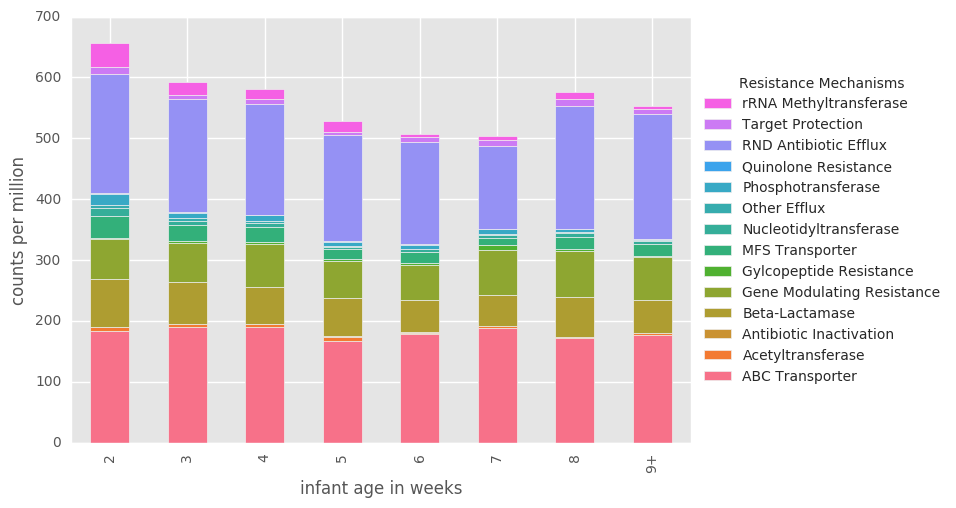

The total resistance cpm (counts per million of resistance genes) has a slight negative correlation with age.          Pearson r = -0.10, p = 0.003


In [779]:
def correspond_metadata_and_data(resistance_df):
    """Reorders the sample resistance gene summary dataframe and the metadata dataframe 
    so that they properly correspond, return both ordered dataframes"""
    # connect the samples to the infant using the sample_metadata df
    all_res_gene_summaries2 = sample_resistance_gene_summaries.merge(sample_metadata, on='sample')
    # connect all data using infant sheet
    all_res_gene_summaries3 = all_res_gene_summaries2.merge(infant_metadata, on='infant')
    # separate the data (resistance gene summaries) and the metadata
    samples = all_res_gene_summaries3['sample']
    res_gene_summaries_only = all_res_gene_summaries3.iloc[:, 2:172] # select resfams columns
    res_gene_summaries_only = res_gene_summaries_only.set_index(samples)
    metadata_only = all_res_gene_summaries3.iloc[:, 172:] # select metadata columns
    metadata_only['sample'] = samples
    return(res_gene_summaries_only, metadata_only)

def convert_res_to_category(ordered_resistance_df):
    """Convert each sample from individual res genes to category,
    return dataframe of sample resistance category summaries"""
    # generate a list of mechanisms to classify each Resfam as the appropriate mechanism category
    list_of_RFs = ordered_resistance_df.columns[1:]
    list_of_mechanisms = []
    for RF in list_of_RFs:
        list_of_mechanisms.append(resfams_metadata.loc[resfams_metadata['Resfam ID'] == RF] \
                                  ['Mechanism Classification'])
    new_list_of_mechanisms = []
    for mech in list_of_mechanisms:
        mech = mech.values[0]
        new_list_of_mechanisms.append(mech)
    ordered_resistance_df = ordered_resistance_df.drop(ordered_resistance_df.columns[0], axis=1)
    # rename the columns with the mechanism rather than Resfams accession
    ordered_resistance_df.columns = new_list_of_mechanisms 
    # sum the Resfams belonging to the same mechanism category
    sample_res_category_summaries = ordered_resistance_df.groupby(ordered_resistance_df.columns, axis=1).sum()
    return(sample_res_category_summaries)
    
def make_cat_res_sum_by_week_df(sample_res_category_sum_df):
    """Group the infant samples in the sample resistance 
    gene category summaries by week. Return dataframe grouped by week 
    and original dataframe with DOL added"""
    def label_week(row):
        """Convert day to week."""
        if row['DOL'] >= 8 and row['DOL'] < 15:
            return(2)
        elif row['DOL'] >= 15 and row['DOL'] < 22:
            return(3)
        elif row['DOL'] >= 22 and row['DOL'] < 29:
            return(4)
        elif row['DOL'] >= 29 and row['DOL'] < 36:
            return(5)
        elif row['DOL'] >= 36 and row['DOL'] < 43:
            return(6)
        elif row['DOL'] >= 43 and row['DOL'] < 50:
            return(7)
        elif row['DOL'] >= 50 and row['DOL'] < 57:
            return(8)
        elif row['DOL'] > 57:
            return('9+')
    metadata_ordered.index = sample_res_category_sum.index
    sample_res_category_sum_df['DOL'] = metadata_ordered['DOL'] 
    # remove samples with unusual overabundance leading to outlying high counts
    sample_res_category_sum_df = sample_res_category_sum_df.loc[sample_res_category_sum_df['ABC Transporter']<500]
    # convert days into weeks and group samples by infant week of life
    sample_res_category_sum_df['infant age in weeks'] = sample_res_category_sum_df.apply(lambda row: \
                                                                                         label_week(row),axis=1)
    # calculate the mean resistance mechanism cpm for each week category
    sample_res_cat_by_week0 = sample_res_category_sum_df.groupby('infant age in weeks').mean()
    sample_res_cat_by_week1 = sample_res_cat_by_week0.ix[:,:-1]
    # remove any categories that are entirely zero 
    sample_res_cat_by_week = sample_res_cat_by_week1.loc[:, (sample_res_cat_by_week1 != 0).any(axis=0)]
    return(sample_res_cat_by_week, sample_res_category_sum_df)
    

sample_res_gene_ordered, metadata_ordered = correspond_metadata_and_data(sample_resistance_gene_summaries)

sample_res_category_sum = convert_res_to_category(sample_res_gene_ordered)

sample_res_cat_by_week, sample_res_category_sum_df = make_cat_res_sum_by_week_df(sample_res_category_sum)

# create bar graph displaying infant week and mean resistance content by category
plt.style.use("ggplot")
sns.set_palette(sns.color_palette("husl", 15))
fig = sample_res_cat_by_week.plot(kind='bar', stacked=True)
plt.ylabel('counts per million')
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], title='Resistance Mechanisms', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# calculate Pearson correlation with age using total resistance gene counts of each individual sample
total_counts = sample_res_category_sum_df.sum(axis=1) 
pearson_r, p_value = scipy.stats.pearsonr(sample_res_category_sum_df['DOL'], total_counts)
print('The total resistance cpm (counts per million of resistance genes) has a slight negative correlation with age. \
         Pearson r = {0:.2f}, p = {1:.3f}'.format(pearson_r,p_value))

### PERMANOVA to evaluate impact of clinical factors on resistome

To determine which factors have a significant effect on the distribution of resistance genes in the infant gut microbiome, cross-sectional PERMANOVAs were performed at discrete time points (2, 4, and 6 weeks of age) to overcome the bias of repeated measures in longitudinal sampling. The PERMANOVA partitions the variance associated with individual factors, allowing us to determine each factor's effect on the resistome.

In [780]:
def create_master_data_df(res_gene_df, metadata_df):
    """Using the sample resistance gene summaries and the metadata dataframe,
    generate one dataframe that contains all the data & metadata, which can be later broken
    up for the cross-sectional PERMANOVAs."""
    res_gene_df['sample'] = res_gene_df.index
    # merge metadata with resistance gene data
    res_gene_and_metadata = metadata_ordered.merge(res_gene_df, on='sample') 
    def label_antibiotics(row):
        """Label True if the infant is receiving antibiotics 
        on the day the sample is taken, Label False if it is not
        receiving antibiotics."""
        if row['antibiotics'] == '[]':
            return(False)
        else:
            return(True)
    res_gene_and_metadata['received_breastmilk'] = res_gene_and_metadata.apply(lambda row: \
                                                                               label_breastmilk(row),axis=1)
    res_gene_and_metadata['received_antibiotics'] = res_gene_and_metadata.apply(lambda row: \
                                                                                label_antibiotics(row),axis=1)
    return(res_gene_and_metadata)

def find_first_sample(week_df):
    """Return the name of the sample that is the first
    sample from each infant for a particular week"""
    seen_infant = []
    first_samples = []
    i = 0
    for infant in week_df.infant:
        if infant not in seen_infant:
            seen_infant.append(infant)
            first_samples.append(week_df.ix[i]['sample'])
            i = i + 1
        else:
            i = i + 1
    return(first_samples)

def create_cross_section_dfs(week_df):
    """To avoid having the sample infant appear in multiple samples in the same PERMANOVA,
    select only one sample from each infant to use."""
    first_samples = find_first_sample(week_df)
    week_df_for_permanova = week_df.loc[week_df['sample'].isin(first_samples)]
    return(week_df_for_permanova)

def make_csvs_for_adonis(week_string, selected_week_df):
    """Intake a string indicating the week, and the week's dataframe with first samples.
    Save each week's data and metadata as csv files, for subsequent upload into R,
    so the PERMANOVA can be performed using the adonis2 function in the R package vegan.)"""
    res_gene_df = selected_week_df.iloc[:, 30:200]
    metadata_df = selected_week_df[['received_breastmilk','received_antibiotics',
                                          'birth_mode','gender','maternal_ab']]
    #Save as csv files for transfer to R for PERMANOVA
    res_gene_df.to_csv(week_string+'_res_gene.csv')
    metadata_df.to_csv(week_string+'_metadata.csv')

def bonferroni_correction(p_value, num_tests):
    """Perform bonferonni corrections to adjust for multiple testing when all p-values are not yet
    available but the number of tests is known."""
    corrected_p = p_value * float(num_tests) # Bonferonni corrections multiply the value by the number of tests 
                                             # performed (in the same family of hypotheses)
    if corrected_p > 1:
        corrected_p = 1.0 # corrected p-values above 1 should be reduced to 1
    return(corrected_p)

def make_p_table(week_string, csv):
    """Intake PERMANOVA result csv and a string indicating the week. Bonferonni adjust p_values, since multiple 
    PERMANOVA tests were performed. Return a plotly table."""
    # load csv from R into python pandas dataframe
    result_df = pd.read_csv(csv)
    # give un-abbreviated column names
    result_df = result_df.rename(columns={'Df':'Degrees of freedom', 'SumOfSqs':'Sum of Squares', \
                                          'F':'F-statistic', 'Pr(>F)':"p value"})
    # since three PERMANOVAs are performed, Bonferonni adjust the p-values for multiple testing
    corrected_ps = []
    for p in result_df['p value']:
        corrected_ps.append(bonferroni_correction(p, 3))
    result_df['corrected p value'] = corrected_ps
    # create and return plotly table
    result_df = result_df.fillna(value='')    
    result_df_round = result_df.round(4)
    table = ff.create_table(result_df_round, index=True, index_title=week_string)
    return(table)

master_res_gene_metadata = create_master_data_df(sample_res_gene_ordered, metadata_ordered)

# Create dataframes for weeks 2, 4, and 6, from which to draw samples for the cross-sectional PERMANOVAs
res_gene_and_metadata_week2 = master_res_gene_metadata.loc \
[master_res_gene_metadata['DOL'].between(8, 14) == True].reset_index()
res_gene_and_metadata_week4 = master_res_gene_metadata.loc \
[master_res_gene_metadata['DOL'].between(22, 28) == True].reset_index()
res_gene_and_metadata_week6 = master_res_gene_metadata.loc \
[master_res_gene_metadata['DOL'].between(36, 42) == True].reset_index()

# perform PERMANOVAs
weeks_and_dfs = [('week2', res_gene_and_metadata_week2), ('week4', res_gene_and_metadata_week4),
                 ('week6', res_gene_and_metadata_week6)]
permanova_dfs = []
for week, df in weeks_and_dfs:
    permanova_df = create_cross_section_dfs(df)
    permanova_dfs.append(permanova_df)
    make_csvs_for_adonis(week, permanova_df)

%R library(vegan)

%R sample_resistance_gene_summaries = read.table('week2_res_gene.csv', header=TRUE, sep=",")
%R rownames(sample_resistance_gene_summaries) <- sample_resistance_gene_summaries$index
# Load metadata and generate labels for factors
%R metadata_for_permanova = read.table('week2_metadata.csv', header=TRUE, sep=",")
%R birth_mode <- metadata_for_permanova$birth_mode
%R gender <- metadata_for_permanova$gender
%R maternal_antibiotics <- metadata_for_permanova$maternal_ab
%R infant_antibiotics <- metadata_for_permanova$received_antibiotics
%R received_breastmilk <- metadata_for_permanova$received_breastmilk
# Perform marginal PERMANOVA using Bray-Curtis dissimilarty metric
%R permanova_result <- adonis2(formula = sample_resistance_gene_summaries ~ \
                               received_breastmilk + infant_antibiotics + birth_mode + \
                               gender + maternal_antibiotics, data = sample_resistance_gene_summaries, \
                               method = 'bray', by="margin", parallel = 9, permutations = 9999)
%R write.table(permanova_result, file="week2_permanova_result.csv", sep=",")

%R sample_resistance_gene_summaries = read.table('week4_res_gene.csv', header=TRUE, sep=",")
%R rownames(sample_resistance_gene_summaries) <- sample_resistance_gene_summaries$index
# Load metadata and generate labels for factors
%R metadata_for_permanova = read.table('week4_metadata.csv', header=TRUE, sep=",")
%R birth_mode <- metadata_for_permanova$birth_mode
%R gender <- metadata_for_permanova$gender
%R maternal_antibiotics <- metadata_for_permanova$maternal_ab
%R infant_antibiotics <- metadata_for_permanova$received_antibiotics
%R received_breastmilk <- metadata_for_permanova$received_breastmilk
# Perform marginal PERMANOVA using Bray-Curtis dissimilarty metric
%R permanova_result <- adonis2(formula = sample_resistance_gene_summaries ~ \
                               received_breastmilk + infant_antibiotics + birth_mode + \
                               gender + maternal_antibiotics, data = sample_resistance_gene_summaries, \
                               method = 'bray', by="margin", parallel = 9, permutations = 9999)
%R write.table(permanova_result, file="week4_permanova_result.csv", sep=",")

%R sample_resistance_gene_summaries = read.table('week6_res_gene.csv', header=TRUE, sep=",")
%R rownames(sample_resistance_gene_summaries) <- sample_resistance_gene_summaries$index
# Load metadata and generate labels for factors
%R metadata_for_permanova = read.table('week6_metadata.csv', header=TRUE, sep=",")
%R birth_mode <- metadata_for_permanova$birth_mode
%R gender <- metadata_for_permanova$gender
%R maternal_antibiotics <- metadata_for_permanova$maternal_ab
%R infant_antibiotics <- metadata_for_permanova$received_antibiotics
%R received_breastmilk <- metadata_for_permanova$received_breastmilk
# Perform marginal PERMANOVA using Bray-Curtis dissimilarty metric
%R permanova_result <- adonis2(formula = sample_resistance_gene_summaries ~ \
                               received_breastmilk + infant_antibiotics + birth_mode + \
                               gender + maternal_antibiotics, data = sample_resistance_gene_summaries, \
                               method = 'bray', by="margin", parallel = 9, permutations = 9999)
%R write.table(permanova_result, file="week6_permanova_result.csv", sep=",")

list_of_cvs = [("week2_permanova_result.csv",'Week 2'), 
               ("week4_permanova_result.csv",'Week 4'), 
               ("week6_permanova_result.csv",'Week 6')]

permanova_result_tables = []
for csv, week in list_of_cvs:
    table = make_p_table(week, csv)
    permanova_result_tables.append(table)

In [781]:
py.iplot(permanova_result_tables[0]) # Week 2 PERMANOVA results

In [782]:
py.iplot(permanova_result_tables[1]) # Week 4 PERMANOVA results

In [783]:
py.iplot(permanova_result_tables[2]) # Week 6 PERMANOVA results

### Random forest model and nonparametric test to identify genes influenced by feeding 

The above results from the PERMANOVA test reveal that in weeks 4 and 6, the feeding type (i.e. whether or not the infant received breastmilk) had a significant effect on the infant's gut resistome (p < 0.01). To identify the genes contributing to the differences of breast-fed and formula-fed infant gut resistomes, a random forest model was built, which classified resistomes as belonging to either a breast-fed or formula-fed infant, and feature importance scores were assessed. By selecting a few features for hypothesis testing, the number of comparisons that needed to be made was succesfully reduced from 170 to 4. Mann-Whitney U tests led to the identification of one gene significantly associated with the resistomes of formula-fed infants.

In [784]:
def model_and_test(week_res_gene_df):
    """Takes in a dataframe that combines resistance gene summaries with feeding metadata, and
    trains a random forest model to classify each sample based on feeding type. Returns the most
    important features of the model based on gini importance scores, along with the results of a 
    Mann-Whitney U test on these features."""
    # select resistance gene summaries of breast-fed and formula-fed babies
    breast_formula_connected_df = week_res_gene_df.loc[week_res_gene_df['feeding'] != 'Combination']
    resistance_gene_summaries_df = breast_formula_connected_df.ix[:,30:200]
    res_gene_summaries = resistance_gene_summaries_df.values
    res_gene_summaries_scaled = preprocessing.scale(res_gene_summaries)
    output_array = np.asarray(breast_formula_connected_df['feeding'])
    # Random forest classification
    clf = RandomForestClassifier(n_estimators=10, random_state=1) # the classifier
    clf = clf.fit(res_gene_summaries_scaled, output_array) # fit model
    importances = clf.feature_importances_ # extract feature importances
    indices = np.argsort(importances)[::-1]  
    resfam_ids = sample_res_gene_ordered.columns[:-1] 
    # determine which Resfams were important features
    important_features = []
    resfam_to_score = {}
    i = 0
    for score in importances:
        # select resistance genes with feature importances above 0.07
        if score > 0.07:
            important_features.append(resfam_ids[i])
            resfam_to_score[resfam_ids[i]] = score 
        i = i + 1
    # nonparametric testing of important features (> 0.07) to determine group differences
    breast_df = breast_formula_connected_df.loc[breast_formula_connected_df['feeding'] == 'Breast']
    formula_df = breast_formula_connected_df.loc[breast_formula_connected_df['feeding'] == 'Formula']
    resfam_to_TestResult = {}
    for resfam in important_features:
        breast = breast_df[resfam]
        formula = formula_df[resfam]
        # compare groups with Mann-Whitney U-test
        mann_whitney_u_statistic, p_value = scipy.stats.mannwhitneyu(breast, formula) 
        resfam_to_TestResult[resfam] = (mann_whitney_u_statistic, p_value) 
    # build dataframes of feature_to_score and feature_to_test_result
    resfam_to_score_df = pd.DataFrame.from_dict(resfam_to_score, orient='index')
    resfam_to_score_df = resfam_to_score_df.rename(columns={0: "Feature importance score"})
    resfam_to_TestResult_df = pd.DataFrame.from_dict(resfam_to_TestResult, orient='index')
    resfam_to_TestResult_df = resfam_to_TestResult_df.rename(columns={0: "Mann-Whitney U Statistic", 1: "p value"})
    result_df = resfam_to_score_df.join(resfam_to_TestResult_df, how='outer')
    return(result_df)

weeks_of_interest = [permanova_dfs[1], permanova_dfs[2]] # weeks that showed significant result in PERMANOVA
week_result_dfs = []
for week in weeks_of_interest:
    df = model_and_test(week)
    week_result_dfs.append(df)

cat_df = pd.concat(week_result_dfs)
p_values = cat_df['p value']
# adjust p-values for multiple testing (four tests performed after feature selection through importance scores)
correct = statsmodels.sandbox.stats.multicomp.multipletests(p_values, method='bonferroni') 
cat_df['corrected p value'] = correct[1]
cat_df = cat_df.round(decimals=3)
cat_df['Resfam ID'] = cat_df.index
# convert accession to descriptions
resfams_descriptions = resfams_metadata[['Resfam ID', 'Description']] 
final_df = resfams_descriptions.merge(cat_df, on='Resfam ID')
final_df = final_df.drop('Resfam ID', axis=1)
final_df = final_df.rename(columns={'Description':'Resfam'})
# give abbreviated names to the identified antibiotic resistance genes
shortened_names = ['ANT6','Class D beta-lactamases','mexX', 'soxR mutant']
final_df['Resfam'] = shortened_names
table = ff.create_table(final_df)
py.iplot(table)

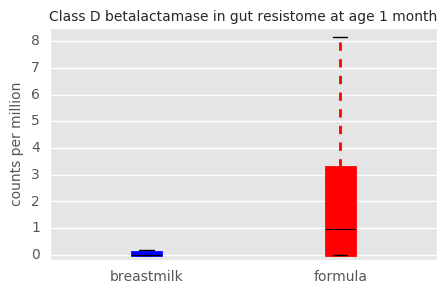

Mann Whitney U = 66.0, p = 0.031


In [817]:
def resize_plot_text(labelsize, titlesize):
    """Resize particular aspects of a matplotlib plot
    based on an input label size and title size."""
    ax = plt.subplot()
    for ticklabel in (ax.get_xticklabels()):
        ticklabel.set_fontsize(labelsize)
    for ticklabel in (ax.get_yticklabels()):
        ticklabel.set_fontsize(labelsize)
    ax.xaxis.get_label().set_fontsize(labelsize)
    ax.yaxis.get_label().set_fontsize(labelsize)
    ax.title.set_fontsize(titlesize)

# Draw boxplot to visualize difference between breast-fed and formula-fed infants for class D betalactamase
week4_res_gene = permanova_dfs[1]
week_4_breast = week4_res_gene.loc[week4_res_gene['feeding']=='Breast']
week_4_formula = week4_res_gene.loc[week4_res_gene['feeding']=='Formula']
corrected_breast = week_4_breast['RF0056'].reset_index()
corrected_formula = week_4_formula['RF0056'].reset_index()
plt.figure(figsize=(5,3))
bp0 = plt.boxplot([corrected_breast['RF0056'], corrected_formula['RF0056']],
                  labels=['breastmilk','formula'], patch_artist=True, showfliers=False )
bp0['boxes'][0].set(color='blue', linewidth=2)
bp0['boxes'][1].set(color='red', linewidth=2)
bp0['whiskers'][3].set(color='red', linewidth=2)
for median in bp0['medians']:
    median.set(color='black', linewidth=0.8)
plt.gca().xaxis.grid(False)
plt.ylim(-0.2,8.5)
plt.ylabel('counts per million')
plt.title('Class D betalactamase in gut resistome at age 1 month')
resize_plot_text(10, 10)
plt.show()
mann_whitney_u_stat = str(final_df.ix[1].values[2]) # extract statistic from mann whitney test result
corrected_p = str(final_df.ix[1].values[4]) # extract boferonni corrected p-value
print('Mann Whitney U = '+mann_whitney_u_stat+', p = '+corrected_p)

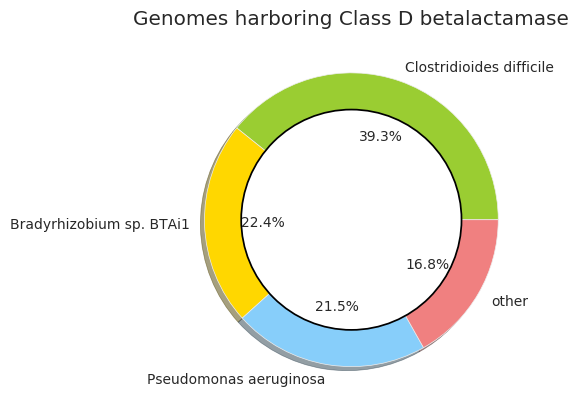

In [786]:
# Determine which species of bacteria is the most frequent carrier of Class D beta-lactamase

# merge genome res summaries with taxonomy
genome_resistance_gene_summaries['genome'] = genome_resistance_gene_summaries.index
genome_resistance_gene_summaries_tax = genome_resistance_gene_summaries.merge(genome_taxonomy, on='genome')

# Identify the genomes that have RF0056 (Class D Betalactamase)
genomes_with_RF0056_df = genome_resistance_gene_summaries_tax.loc[genome_resistance_gene_summaries_tax['RF0056'] > 0]
# 107 out of 1428 genomes have RF0056
# Visualize which species are the most common carriers of this gene
species_RF0056 = genomes_with_RF0056_df['taxonomy']
# count the number of each taxonomy that contains RF0056
species_RF0056_freq_dict = collections.Counter(species_RF0056)
# order the dictionary by which species are the most frequent carriers
species_most_common = species_RF0056_freq_dict.most_common()
# the total number of genomes carrying the RF0056 gene
total = sum(species_RF0056_freq_dict.values())
# the top three species and all the others grouped into "other"
minus_top_three = total - (species_most_common[0][1]+species_most_common[1][1]+species_most_common[2][1])
# create a donut chart that displays the breakdown
labels = species_most_common[0][0], species_most_common[1][0], species_most_common[2][0], 'other'
sizes = [species_most_common[0][1]/total, species_most_common[1][1]/total, \
         species_most_common[2][1]/total, minus_top_three/total]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0, 0, 0, 0)  # explode a slice if required
plt.figure(figsize=(4.3,4.3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Genomes harboring Class D betalactamase')
plt.tight_layout()
plt.show()  


### _Clostridium difficile_ with Class D betalactamase and the connection to formula-fed infants

In the visualizations above, it is shown that Class D betalactamase is enriched in formula-fed infants and the species that most frequently harbors this gene is _Clostridiodes difficile_, also known as _Clostridium difficile_. Phylogenetic analysis (through alignment of RPS3 gene with MUSCLE and generation of maximum-liklihood phylogenetic tree with raXml) revealed that the _C. difficile_ harboring the Class D betalactamase formed a clonal group. The phylogenetic tree can be built using the alignment fasta file in this github repository. Next, we decipher the abundance dynamics of _C. difficile_. The analysis shows that _C. difficile_ with Class D betalactamase is consistently more abundant in formula-fed infants than _C. difficile_ without this gene. The presence of one gene that may be involved in carbohydrate transport is perfectly correlated with the presence of Class D betalactamase.

In [834]:
%%bash

# unzip the folder of relative abundance data
unzip -q relative_abundance.zip

# create a file with a list of the rel abun csv names
ls relative_abundance_csvs/ > rel_abun_filenames.txt

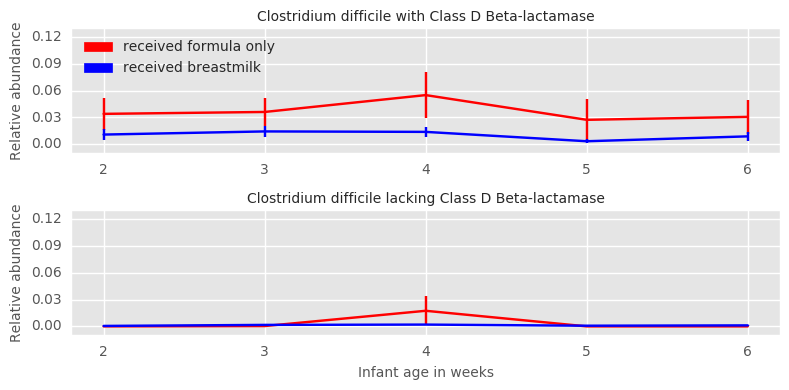

In [788]:
def create_list_of_dfs(file):
    """Takes in a filename of a file containing a list of csvs, 
    converts these csvs to dataframe, store them in a list and
    return the list."""
    list_of_dfs = []
    f = open(file)
    for line in f:
        name = line.split('\n')[0]
        data = pd.read_csv('relative_abundance_csvs/'+name)
        list_of_dfs.append(data)
    f.close()
    return(list_of_dfs)

def select_genome(df, species):
    """Select genomes of a species of interest from a dataframe
    with a taxonomy column, return the selected part of the dataframe
    and list of these genomes."""
    species_df = df.loc[df['taxonomy'] == species]
    list_of_genomes = species_df['genome'].tolist()
    return(species_df, list_of_genomes)

def sum_genome_groups(list_of_dfs):
    """Take in a list of dataframs, and based on a classification 
    listed in a classification column in each dataframe, sum the values 
    for each member of each class to come up with values for the group 
    as a whole. Return one concatenated dataframe."""
    rel_abun_dfs_of_interest = []
    for df in list_of_dfs:
        abun_cols = [col for col in df.columns if 'abun' in col]
        df2 = df.filter(items=abun_cols)
        df2['classification'] = df['classification']
        cdif_abun_df = df2.groupby('classification').sum()
        rel_abun_dfs_of_interest.append(cdif_abun_df)
    all_samples_df = pd.concat(rel_abun_dfs_of_interest, axis=1)
    all_samples_df = all_samples_df.fillna(0)
    return(all_samples_df)

def abundance_through_time_by_feeding(groups_to_test, week_dfs, all_sample_df, metadata_df):
    """Returns a list of lists of the groups' relative abundance through the
    weeks specified by the week dfs, along with the list of lists of standard
    errors for each of those datapoints, grouped by feeding type."""
    group_to_results = {}
    group_to_error = {}
    for group in groups_to_test:
        formula_abundance_datapoints = []
        all_y_error_formula = []
        breast_abundance_datapoints = []
        all_y_error_breast = []
        for df in week_dfs:
            week_X_samples = find_first_sample(df)
            week_X_cols = [col for col in all_sample_df.columns if col[:12] in week_X_samples]
            week_X_species_matrix = all_sample_df.filter(items=week_X_cols)
            week_X_data_matrix1 = week_X_species_matrix.transpose()
            week_X_data_matrix2 = week_X_data_matrix1.loc[~(week_X_data_matrix1==0).all(axis=1)]
            week_X_sample_list = []
            for entry in week_X_data_matrix2.index:
                week_X_sample_list.append(entry[:12])
            week_X_data_matrix2['sample'] = week_X_sample_list
            week_X_data_matrix_feeding = week_X_data_matrix2.merge(metadata_df, on='sample', how='inner')
            week_X_data_matrix_feeding.index = week_X_data_matrix2['sample']
            week_X_data_matrix_breast = week_X_data_matrix_feeding.loc \
                                        [week_X_data_matrix_feeding['received_breastmilk']==True]
            week_X_data_matrix_formula = week_X_data_matrix_feeding.loc \
                                        [week_X_data_matrix_feeding['received_breastmilk'] != True]
            mean_abun_for_formula = week_X_data_matrix_formula[group].mean()
            formula_abundance_datapoints.append(mean_abun_for_formula)
            mean_abun_for_breast = week_X_data_matrix_breast[group].mean()
            breast_abundance_datapoints.append(mean_abun_for_breast)
            y_error_formula = scipy.stats.sem(week_X_data_matrix_formula[group], ddof=0)
            all_y_error_formula.append(y_error_formula)
            y_error_breast = scipy.stats.sem(week_X_data_matrix_breast[group], ddof=0)
            all_y_error_breast.append(y_error_breast)
        group_to_results[group] = [formula_abundance_datapoints, breast_abundance_datapoints]
        group_to_error[group] = [all_y_error_formula, all_y_error_breast]
    return(group_to_results, group_to_error)

    
rel_abun_dfs = create_list_of_dfs('rel_abun_filenames.txt')

genomes_with_RF0056_df = genome_resistance_gene_summaries_tax.loc \
                        [genome_resistance_gene_summaries_tax['RF0056'] > 0]
c_dif_with_RF0056_df, c_dif_with_RF0056 = select_genome(genomes_with_RF0056_df, 'Clostridioides difficile')

genomes_lacking_RF0056_df = genome_resistance_gene_summaries_tax.loc \
                            [genome_resistance_gene_summaries_tax['RF0056'] == 0]
c_dif_lacking_RF0056_df, c_dif_lacking_RF0056 = select_genome(genomes_lacking_RF0056_df, 'Clostridioides difficile')

# For each rel_abun_df, identify and label C. difficile with and without RF0056
for df in rel_abun_dfs:
    classification_list = []
    for genome in df['genome']:
        if genome+'.fa' in c_dif_with_RF0056:
            classification_list.append('c_dif_with_RF0056')
        elif genome+'.fa' in c_dif_lacking_RF0056:
            classification_list.append('c_dif_lacking_RF0056')
        else:
            classification_list.append('neither')
    df['classification'] = classification_list

all_samples_cdif_abun_df = sum_genome_groups(rel_abun_dfs)

# Data frames for weeks 2, 4, and 6 have already been created, do the same for weeks 3 and 5
res_gene_and_metadata_week3 = master_res_gene_metadata.loc \
                            [master_res_gene_metadata['DOL'].between(15, 21) == True].reset_index()
res_gene_and_metadata_week5 = master_res_gene_metadata.loc \
                            [master_res_gene_metadata['DOL'].between(29, 35) == True].reset_index()
week_dfs = [res_gene_and_metadata_week2, res_gene_and_metadata_week3, res_gene_and_metadata_week4,
           res_gene_and_metadata_week5, res_gene_and_metadata_week6]
groups_to_test = ['c_dif_with_RF0056', 'c_dif_lacking_RF0056']
# calculate relative abundance datapoints and standard error for error bars for each datapoint
datapoints_dict, error_dict = abundance_through_time_by_feeding(groups_to_test, week_dfs, all_samples_cdif_abun_df,
                                                               master_res_gene_metadata)

# Generate figure to show the abundance of C. difficile groups (with and without RF0056) over time
fig = plt.figure(figsize=(8,4))
ax1 = plt.subplot(2,1,1)
plt.title("Clostridium difficile with Class D Beta-lactamase")
formula_points = datapoints_dict['c_dif_with_RF0056'][0]
breast_points = datapoints_dict['c_dif_with_RF0056'][1]    
ax1.errorbar(x=np.arange(0,5), y=formula_points, yerr=error_dict['c_dif_with_RF0056'][0], color='red')
ax1.errorbar(x=np.arange(0,5), y=breast_points, yerr=error_dict['c_dif_with_RF0056'][1], color='blue')
leg = plt.legend(handles=[formula, breast], loc='upper left', prop={'size': 10})
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Relative abundance')
plt.legend()
plt.ylim(-0.01,0.13)
plt.xlim(-0.2,4.2)
ax1.set_xticklabels(["",2,3,4,5,6])
ax1.yaxis.set_ticks(np.arange(0, 0.15, 0.03))
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(10)
formula = mpatches.Patch(color='red', label='received formula only')
breast = mpatches.Patch(color='blue', label='received breastmilk')

ax2 = plt.subplot(2,1,2)
plt.title("Clostridium difficile lacking Class D Beta-lactamase")
formula_points = datapoints_dict['c_dif_lacking_RF0056'][0]
breast_points = datapoints_dict['c_dif_lacking_RF0056'][1]    
ax2.errorbar(x=np.arange(0,5), y=formula_points, yerr=error_dict['c_dif_lacking_RF0056'][0], color='red')
ax2.errorbar(x=np.arange(0,5), y=breast_points, yerr=error_dict['c_dif_lacking_RF0056'][1], color='blue')
plt.ylabel('Relative abundance')
plt.xlabel('Infant age in weeks')
plt.legend()
plt.ylim(-0.01,0.13)
plt.xlim(-0.2,4.2)
ax2.set_xticklabels(["",2,3,4,5,6])
ax2.yaxis.set_ticks(np.arange(0, 0.15, 0.03))
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(10)

plt.tight_layout()
plt.show()

In [789]:
# To explore possible reasons why C. difficile with Class D betalactamase has a selective advantage 
# in formula-fed infants, search for metabolic pathways correlated with Class D betalactamase

def make_accession_dict(kegg_annotation_df, resfams_metadata_df):    
    """Return a dictionary that connects the accession numbers of Resfams and KEGG modules
    (keys in the dictionary) to the full descriptions of the genes or pathways (values)."""
    accession_to_gene_dict = {}
    for module in kegg_annotation_df.Module:
        description = kegg_annotation_df.loc[kegg_annotation_df['Module']==module]['Description']
        pathway = description.to_string()[1:]
        accession_to_gene_dict[module] = pathway
    for accession in resfams_metadata_df['Resfam ID']:
        description = resfams_metadata_df.loc[resfams_metadata_df['Resfam ID']==accession]['Description']
        gene = description.to_string()[1:]
        accession_to_gene_dict[accession] = gene
    return(accession_to_gene_dict)

def calculate_kegg_correlation(genome_res_df, KEGG_genome_profiles, resfam_accession):
    """Calculates pairwise Pearson correlation coefficients for a Resfam with 
    all the KEGG modules, for a particular set of genomes in the input 
    dataframe of genome resistance gene summaries."""
    KEGG_results_df_t = KEGG_genome_profiles.transpose()
    KEGG_results_df_t.columns = KEGG_results_df_t.ix[0]
    KEGG_results_df_t['genome'] = KEGG_results_df_t.index
    merged_df = KEGG_results_df_t.merge(genome_res_df, on='genome')
    modules_df = merged_df.ix[:,:614]
    modules_df[resfam_accession] = merged_df[resfam_accession]
    modules_df = modules_df.astype(float)
    correlation_df = modules_df.corr()
    sorted_resfam_corr = correlation_df.sort_values(by=resfam_accession, ascending=False)[resfam_accession]
    sorted_resfam_corr_df = sorted_resfam_corr.to_frame()
    # Instead of module accession numbers, list the descriptive names of the modules
    description_replacements = []
    for accession in sorted_resfam_corr_df.index:
        description = accession_to_gene_dict[accession]
        description_replacements.append(description)
    sorted_resfam_corr_df['description'] = description_replacements
    return(sorted_resfam_corr_df)

def find_perfect_correlations(corr_df, value_of_interest):
    """Using the input correlation dataframe, identify the variable that is
    perfectly correlated with the value of interest (Pearson correlation coefficient = 1.0)."""
    perfect_corrs = corr_df.loc[corr_df[value_of_interest] == 1]
    perfect_corrs = perfect_corrs.loc[perfect_corrs.index != value_of_interest]
    return(perfect_corrs)
    
c_dif_genome_res_df, c_dif_genomes = select_genome(genome_resistance_gene_summaries_tax, 'Clostridioides difficile')
accession_to_gene_dict = make_accession_dict(KEGG_genome_profiles, resfams_metadata)
modules_corr_with_RF0056 = calculate_kegg_correlation(c_dif_genome_res_df, KEGG_genome_profiles, 'RF0056')
correlated_module = find_perfect_correlations(modules_corr_with_RF0056, 'RF0056')
# the CMP-KDO biosynthesis always appears in C. difficile genomes containing Class D betalactamase (Pearson's r = 1.0)
print(correlated_module) 

# There are mutiple genes that could potentially appear in the CMP-KDO biosynthesis module
# Determine which gene(s) from that module actually in the C. difficile genomes
KEGG_gene_annotations_c_dif = KEGG_gene_annotations.loc[KEGG_gene_annotations['Bin'].isin(c_dif_genomes)]
M00063_in_c_dif = KEGG_gene_annotations_c_dif.loc[KEGG_gene_annotations_c_dif['Module']=='M00063']
genes = M00063_in_c_dif['Description'].unique()

print('\n The following gene(s) in the module correlated with Class D betalactamase occur in C. difficile: ')
for gene in genes:
    print(gene)

        RF0056                description
M00063     1.0  1    CMP-KDO biosynthesis

 The following gene(s) in the module correlated with Class D betalactamase occur in C. difficile: 
arabinose-5-phosphate isomerase [EC:5.3.1.13]


### Exploring the relationship between replication rate and antibiotic resistance

The replication rate of a microbial population can be inferred by calculating an index of replication (iRep). This section elucidates the influence that antibiotic resistance genes may have on the replication rate of bacteria. First, we explore whether the total resistance content of a sample is correlated with the mean replication rate. Then, we test all resistance gene mechanisms to determine if genes of a particular category are intrinsicially associated with higher iRep for a genome, and repeat this analysis within individual phyla. 

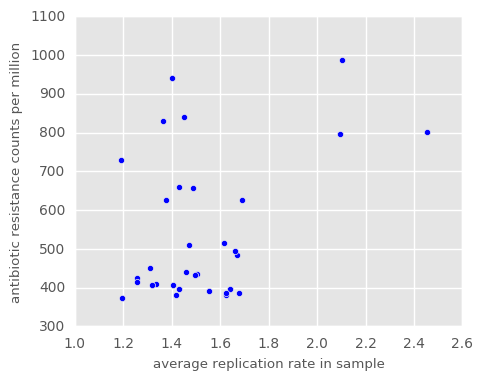

Pearson's r =  0.393594869605 p =  0.0258303132018


In [837]:
def add_phylum(df):
    """For an input dataframe with a column containing the taxonomy, extract the phylum
    from the taxonomy string and add it as a new column in the dataframe."""
    split_taxonomy_strings = df['taxonomy_string'].str.split("|")
    phyla = []
    for entry in split_taxonomy_strings:
        try:
            phylum = entry[3]
            phyla.append(phylum)
        except IndexError:
            phylum = ""
            phyla.append(phylum)
    df['phylum'] = phyla
    return df

def after_abx_samples(df):
    """From a dataframe containing both sample resistance gene summaries and metadata, return
    a dataframe of samples that were taken within five days after postweek antibiotic treatment."""
    abx_babies_data = df.loc[df.postweek_ab == True]
    abx_babies_postweek_data = abx_babies_data.loc[abx_babies_data.DOL > 7]
    samples_with_abx = abx_babies_postweek_data.loc[abx_babies_postweek_data.antibiotics != '[]']
    infant_to_DOLs = {}
    for infant in samples_with_abx.infant:
        list_of_DOLs = []
        this_infant = samples_with_abx.loc[samples_with_abx.infant == infant]
        infant_to_DOLs[infant] = []
        for DOL in this_infant.DOL:
            infant_to_DOLs[infant].append(DOL)
    DOLs_after_abx = {}
    for infant in list(infant_to_DOLs.keys()):
        list_of_DOLs = infant_to_DOLs[infant]
        DOLs_after_abx[infant] = []
        for DOL in list_of_DOLs:
            DOL_plus1 = DOL + 1
            DOLs_after_abx[infant].append(DOL_plus1)
            DOL_plus2 = DOL + 2
            DOLs_after_abx[infant].append(DOL_plus2)
            DOL_plus3 = DOL + 3
            DOLs_after_abx[infant].append(DOL_plus3)
            DOL_plus4 = DOL + 4
            DOLs_after_abx[infant].append(DOL_plus4)
            DOL_plus5 = DOL + 5
            DOLs_after_abx[infant].append(DOL_plus5)
        DOLs_after_abx[infant] = list(set(DOLs_after_abx[infant])) #unique DOLs
    samples_5days_after = []
    for infant in list(DOLs_after_abx.keys()):
        this_infant = abx_babies_postweek_data.loc[abx_babies_postweek_data['infant'] == infant]
        after_abx_samples = this_infant.loc[this_infant.DOL.isin(DOLs_after_abx[infant])]
        samples_5days_after.append(after_abx_samples)
    after_abx_df = pd.concat(samples_5days_after)
    return(after_abx_df)

def mean_sample_iRep(iRep_df, samples_of_interest_df):
    """Using a dataframe containing iRep values, find the mean iRep for each sample and subset
    to only include samples listed in a samples of interest dataframe."""
    mean_iRep_for_samples = iRep_df.groupby('sample')['iRep'].mean()
    mean_iRep_for_samples = mean_iRep_for_samples.to_frame()
    mean_iRep_for_samples = mean_iRep_for_samples.reset_index(level=0)
    mean_iRep_for_samples_of_interest = mean_iRep_for_samples.loc \
                                        [mean_iRep_for_samples['sample'].isin(samples_of_interest_df['sample'])]
    return(mean_iRep_for_samples_of_interest)
    
iRep_filter = iRep_info.loc[iRep_info['iRep'] < 3] # iRep values over 3 are unreliable and may indicate genome 
                                                   # contamination/strain variation
iRep_df = add_phylum(iRep_filter)
after_abx_res_gene_metadata = after_abx_samples(master_res_gene_metadata)
mean_iRep_for_after_abx_samples = mean_sample_iRep(iRep_df, after_abx_res_gene_metadata)
# Create scatterplot showing the relationship between sample's mean iRep and total resistance gene content,
    # for samples within five days of postweek antibiotic treatment
sample_resistance_gene_summaries_fixed = sample_resistance_gene_summaries.drop('index', axis=1)
sample_resistance_gene_summaries_fixed['total'] = \
                sample_resistance_gene_summaries_fixed.drop('sample',axis=1).astype(float).sum(axis=1)
iRep_and_ARG = mean_iRep_for_after_abx_samples.merge(sample_resistance_gene_summaries_fixed, on='sample')
# samples with overabundance leading to unusually high counts not included
iRep_and_ARG_r_o = iRep_and_ARG.loc[iRep_and_ARG['total'] < 1400] 
plt.figure(figsize=(5,4))
plt.scatter(iRep_and_ARG_r_o['iRep'], iRep_and_ARG_r_o['total'])
plt.ylabel('antibiotic resistance counts per million')
plt.xlabel('average replication rate in sample')
plt.show()

pearson_r, p_value = scipy.stats.pearsonr(iRep_and_ARG_r_o['iRep'], iRep_and_ARG_r_o['total'])
print("Pearson's r = ", pearson_r, "p = ", p_value)


Even within the same taxonomic group (Firmicutes), members harboring MFS Transporter 
 replicate at significantly higher rates than those lacking MFS Transporter. 
 (Mann Whitney U = 136756.0   p = 0.000217531513864)
In all Bacteria, members with MFS replicate faster 
 (Mann Whitney U = 827176.0, p = 1.55076289871e-05)


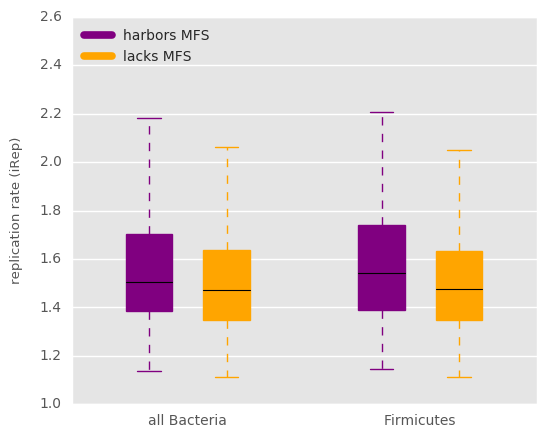

In [840]:
# Look only at samples of infants that did not receive postweek antibiotics to avoid confounding effects
samples_of_no_abx_babies = master_res_gene_metadata.loc[master_res_gene_metadata['postweek_ab'] == False]['sample']
iRep_df_of_no_abx_babies = iRep_df.loc[iRep_df['sample'].isin(samples_of_no_abx_babies)]
genome_resistance_gene_summaries = genome_resistance_gene_summaries.drop('genome',axis=1)
genome_res_by_category = convert_res_to_category(genome_resistance_gene_summaries)
genome_res_by_category['genome'] = genome_res_by_category.index

def test_iRep_difference(iRep_df, genome_res_df):
    """Performs a Mann-Whitney U test on the iRep values of genomes harboring the resistance gene/mechanism
    of interest and those that lack this gene/mechanism within the same phylum, 
    followed by Bonferonni corrections to adjust for multiple testing."""
    res_to_result_dict = {} # Dictionary containing the results of Mann-Whitney U test on iRep values of genomes 
    p_values = []
    u_statistics = []
    for res_of_interest in genome_res_by_category.columns:
        if res_of_interest != 'genome':
            plus_genome = genome_res_by_category.loc[genome_res_by_category[res_of_interest] > 0]['genome'] #has gene
            minus_genome = genome_res_by_category.loc[genome_res_by_category[res_of_interest] == 0]['genome'] #lacks it
            plus_iRep = iRep_df.loc[iRep_df['genome'].isin(plus_genome)]['iRep']
            minus_iRep = iRep_df.loc[iRep_df['genome'].isin(minus_genome)]['iRep']
            u_statistic, p_value = scipy.stats.mannwhitneyu(plus_iRep, minus_iRep)
            p_values.append(p_value)
            u_statistics.append(u_statistic)
    correct_ps = statsmodels.sandbox.stats.multicomp.multipletests(p_values, method='bonferroni')[1]
    i = 0
    for res_of_interest in genome_res_by_category.columns:
        if res_of_interest != 'genome': 
            res_to_result_dict[res_of_interest] = [u_statistics[i], correct_ps[i]]
            i += 1
    phylum_dict = {}
    p_values = []
    u_statistics = []
    num_comparisons = 0
    for key,value in res_to_result_dict.items():
        if value[1] < 0.05:
            # this code block counts the comparisons that need to be made
            # required for my implementation of Bonferonni correction, used rather than built-in 
            # statsmodels version due to dictionary-induced loss of order
            plus_genome = genome_res_by_category.loc[genome_res_by_category[key] > 0]['genome'] #has gene
            minus_genome = genome_res_by_category.loc[genome_res_by_category[key] == 0]['genome'] #lacks gene
            plus_iRep_df = iRep_df.loc[iRep_df['genome'].isin(plus_genome)]
            minus_iRep_df = iRep_df.loc[iRep_df['genome'].isin(minus_genome)]
            phyla_in_plus = set(plus_iRep_df['phylum'])
            phyla_in_minus = set(minus_iRep_df['phylum'])
            phyla_of_both = phyla_in_plus.intersection(phyla_in_minus)
            num_comparisons += len(phyla_of_both)
    for key,value in res_to_result_dict.items():
        if value[1] < 0.05:
            # for significant category, find members of the same phylum that do and do not have this gene
            # and perform mann-whitney u-test followed by Bonferonni correction
            plus_genome = genome_res_by_category.loc[genome_res_by_category[key] > 0]['genome'] #has gene
            minus_genome = genome_res_by_category.loc[genome_res_by_category[key] == 0]['genome'] #lacks gene
            plus_iRep_df = iRep_df.loc[iRep_df['genome'].isin(plus_genome)]
            minus_iRep_df = iRep_df.loc[iRep_df['genome'].isin(minus_genome)]
            phyla_in_plus = set(plus_iRep_df['phylum'])
            phyla_in_minus = set(minus_iRep_df['phylum'])
            phyla_of_both = phyla_in_plus.intersection(phyla_in_minus)
            for phylum in phyla_of_both:            
                iRep_plus = plus_iRep_df.loc[plus_iRep_df['phylum']==phylum]['iRep']
                iRep_minus = minus_iRep_df.loc[minus_iRep_df['phylum']==phylum]['iRep']
                u_statistic, p_value = scipy.stats.mannwhitneyu(iRep_plus, iRep_minus)
                corrected_p = bonferroni_correction(p_value, num_comparisons)
                phylum_dict[phylum] = [key, u_statistic, corrected_p]
    return(phylum_dict)

def setBoxColors(bp):
    setp(bp['boxes'][0], color='purple')
    setp(bp['caps'][0], color='purple')
    setp(bp['caps'][1], color='purple')
    setp(bp['whiskers'][0], color='purple')
    setp(bp['whiskers'][1], color='purple')
    setp(bp['medians'][0], color='purple')

    setp(bp['boxes'][1], color='orange')
    setp(bp['caps'][2], color='orange')
    setp(bp['caps'][3], color='orange')
    setp(bp['whiskers'][2], color='orange')
    setp(bp['whiskers'][3], color='orange')
    setp(bp['medians'][1], color='orange')

phylum_dict = test_iRep_difference(iRep_df_of_no_abx_babies, genome_res_by_category)

# Reveal the resistance category/phylum cobinations that show significant differences in regard to iRep
for key, value in phylum_dict.items():
    if value[2] < 0.05:
        phylum = key
        resistance_category = value[0]
        u_statistic = str(value[1])
        corrected_p = str(value[2])
        print('Even within the same taxonomic group ('+phylum+'), members harboring '+resistance_category+
              ' \n replicate at significantly higher rates than those lacking '+resistance_category
              +'. \n (Mann Whitney U = '+u_statistic+ '   p = '+corrected_p+')')

# Create boxplot displaying the difference in iRep between bacteria with and without MFS genes    
MFS_plus_iRep_df = iRep_df_of_no_abx_babies.loc[iRep_df_of_no_abx_babies['genome'].isin(MFS_plus_genome)]
MFS_plus_iRep = MFS_plus_iRep_df['iRep']
MFS_minus_iRep_df = iRep_df_of_no_abx_babies.loc[iRep_df_of_no_abx_babies['genome'].isin(MFS_minus_genome)]
MFS_minus_iRep = MFS_minus_iRep_df['iRep']
MFS_minus_iRep_df_Firmicutes = MFS_minus_iRep_df.loc[MFS_minus_iRep_df['phylum']=='Firmicutes']
MFS_plus_iRep_df_Firmicutes = MFS_plus_iRep_df.loc[MFS_plus_iRep_df['phylum']=='Firmicutes']
data = [MFS_plus_iRep, MFS_minus_iRep]
u_1, p_1 = scipy.stats.mannwhitneyu(MFS_plus_iRep, MFS_minus_iRep)
p_1_corrected = bonferroni_correction(p_1, 13)
print('In all Bacteria, members with MFS replicate faster \n (Mann Whitney U = '+str(u_1)+', p = '+str(p_1_corrected)+')')
data2 = [MFS_plus_iRep_df_Firmicutes['iRep'], MFS_minus_iRep_df_Firmicutes['iRep']]
u_2, p_2 = scipy.stats.mannwhitneyu(MFS_plus_iRep_df_Firmicutes['iRep'], MFS_minus_iRep_df_Firmicutes['iRep'])
p_2_corrected = bonferroni_correction(p_2, 20)

fig = plt.figure(figsize=(6,5))
ax = plt.axes()
# first boxplot pair
bp = plt.boxplot(data, positions = [1, 2], widths = 0.6, showfliers=False, patch_artist=True)
setBoxColors(bp)
for median in bp['medians']:
    median.set(color='black', linewidth=0.8,)
# second boxplot pair
bp = plt.boxplot(data2, positions = [4, 5], widths = 0.6, showfliers=False, patch_artist=True)
setBoxColors(bp)
# set axes limits and labels
xlim(0,6)
ylim(1,2.6)
ax.set_xticklabels(['all Bacteria', 'Firmicutes'])
ax.set_xticks([1.5, 4.5])
hB, = plot([1,1],'purple')
hR, = plot([1,1],'orange')
plt.legend((hB, hR),('harbors MFS', 'lacks MFS'),loc='upper left')
hB.set_visible(False)
hR.set_visible(False)
leg = plt.gca().get_legend()
llines = leg.get_lines()
for median in bp['medians']:
    median.set(color='black', linewidth=0.8,)
plt.setp(llines, linewidth=5.5) 
plt.gca().xaxis.grid(False)
plt.ylabel('replication rate (iRep)', labelpad=12)
plt.show()

### Early-life changes in antibiotic resistance

The microbial community of the infant gut is known to change from the first month to the second month, with the addition of new gut colonists. Here we connect infant samples from the first month to samples of the same infant in the second month in a nonparametric repeated measures test, to determine if there are any resistance mechanisms that show a change in abundance in the gut resistome over the course of one month.

From the first month of life to the second, the abundance of MFS Transporter               
 in an infant's resistome changes.               
 (Wilcoxon signed-rank W = 165.0, p = 0.0208074168142)


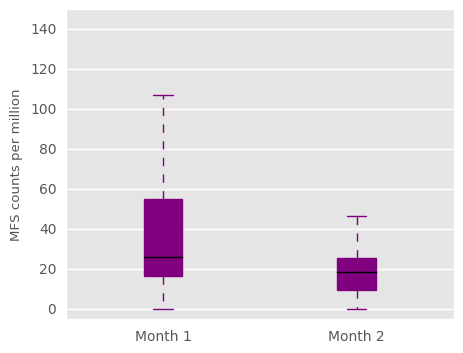

In [819]:
def add_infant_column(df):
    """Using the sample name, add a column to a dataframe
    to indicate which infant each row belongs to."""
    samples = df['sample']
    infants = []
    for sample in samples:
        infant = "_".join(sample.split("_")[:2])
        infants.append(infant)
    df['infant'] = infants
    return(df)

def perform_wilxocon_rank(merged_df, variables_to_test):
    """On one input dataframe, containing repeated measured labeled with _x and _y,
    perform a Wilcoxon signed rank test, followed by Bonferonni p-value corrections.
    Print any variables that show a significant difference."""
    p_values = []
    W_statistics = []
    for cat in sample_res_category_sum.columns[:-3]:
        month1_code = cat+'_x' # month 1 is x when merged dataframe has duplicate values
        month2_code = cat+'_y' # month 2 is y when merged dataframe has duplicate values
        W, P = scipy.stats.wilcoxon(merged_df[month1_code], merged_df[month2_code]) # wilcoxon rank sum test
        p_values.append(P)
        W_statistics.append(W)
    corrected_ps = statsmodels.sandbox.stats.multicomp.multipletests(p_values, method='bonferroni')
    indices_of_interest = []
    i = 0
    for boolean in corrected_ps[0]:
        # find significant (corrected) p values and store the index
        if boolean == True:
            indices_of_interest.append(i)
        else:
            i += 1
    for j in indices_of_interest:
        # extract the resistance mechanisms for which there is a significant difference 
        resistance_mechanism = sample_res_category_sum.columns[:-3][j]
        Wilcoxon_statistic = str(W_statistics[j])
        corrected_p = str(corrected_ps[1][j])
        print("From the first month of life to the second, the abundance of "+resistance_mechanism+" \
              \n in an infant's resistome changes. \
              \n (Wilcoxon signed-rank W = "+Wilcoxon_statistic+", p = "+corrected_p+")")
    
def setBoxColors2(bp):
    setp(bp['boxes'][0], color='purple')
    setp(bp['boxes'][1], color='purple')
    setp(bp['caps'][0], color='purple')
    setp(bp['caps'][2], color='purple')
    setp(bp['caps'][1], color='purple')
    setp(bp['caps'][3], color='purple')
    setp(bp['whiskers'][0], color='purple')
    setp(bp['whiskers'][2], color='purple')
    setp(bp['whiskers'][1], color='purple')
    setp(bp['whiskers'][3], color='purple')
    setp(bp['medians'][0], color='black')
    setp(bp['medians'][1], color='black')

# pull out samples in months 1 and 2 into respective dataframes
res_gene_and_metadata_month1 = master_res_gene_metadata.loc \
                                [master_res_gene_metadata['DOL'].between(1, 30) == True].reset_index()
res_gene_and_metadata_month2 = master_res_gene_metadata.loc \
                                [master_res_gene_metadata['DOL'].between(31, 60) == True].reset_index()
# for each infant, identify the first sample of the month
month_1_samples = find_first_sample(res_gene_and_metadata_month1)
month_2_samples = find_first_sample(res_gene_and_metadata_month2)

sample_res_category_sum['sample'] = sample_res_category_sum.index
sample_res_category_sum = add_infant_column(sample_res_category_sum) # indicate infant of origin for each sample
# select samples to be used in test (first sample of each month)
month1_res_gene = sample_res_category_sum.loc[sample_res_category_sum['sample'].isin(month_1_samples)] 
month2_res_gene = sample_res_category_sum.loc[sample_res_category_sum['sample'].isin(month_2_samples)]

merged_df = month1_res_gene.merge(month2_res_gene, on='infant') #x is month1, y is month2

perform_wilxocon_rank(merged_df, sample_res_category_sum.columns[:-3]) #wilcoxon rank sum test 

# Plot change in abundance of the one resistance category that shows a significant difference between months
fig = plt.figure(figsize=(5,4))
bp = plt.boxplot([merged_df['MFS Transporter_x'], merged_df['MFS Transporter_y']], 
                 widths = 0.2, labels=['Month 1', 'Month 2'],
                 showfliers=False, patch_artist=True)
setBoxColors2(bp)
plt.gca().xaxis.grid(False)
plt.ylim(-5,150)
plt.ylabel('MFS counts per million')
plt.show()

### Predicting a gut organism’s response to antibiotics

This is a model that uses the gene content of a gut organism to predict its direction of change in relative abundance (increase vs. decrease) after a premature infant is administered a combination of vancomycin and cephalosporin antibiotics. To land upon this model, several rounds of adjusting model scope, engineering, transforming, & selecting features, varying algorithm choice, and tuning parameters were employed. However, only the final model (AdaBoost algorithm applied to five pricipal components of combined Resfams and KEGG data) is shown here. 

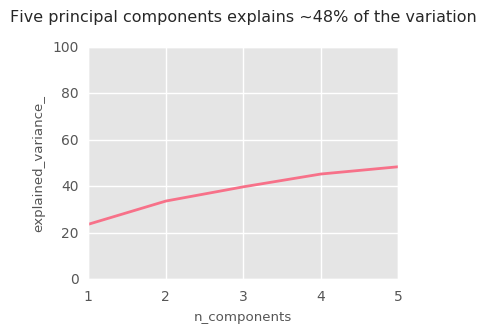

Principal components generated from combined Resfams (resistance) and KEGG (overall metabolism) annotations.


In [856]:
def label_class(list_of_dfs, infant_to_info_dict):
    """Based on a genome's abundances before antibiotics and after antibiotics,
    return a dictionary that indicates whether it increased or decreased in abundance."""
    def make_genome2samples_dict(list_of_dfs, infant_to_info_dict):
        """Intake a list of dataframes containing time-series relative abundance data for each infant,
        and return a dictionary with genomes as keys and the pre- & post- antibiotic samples in a list
        as the dictionary's values."""
        def identify_genomes(df):
            """Select the genomes to be used in the model."""
            for sample in df.columns:
                for before_sample in before_samples:
                    if sample.startswith(before_sample):
                        before_abx_genome_abundances = df[sample]
                        selected_genomes = []
                        for number in before_abx_genome_abundances:
                            if number >= 0.0001: # include genome if it was detectable above this 
                                                 # relative abundance level in the pre-antibiotic sample
                                genome = df.loc[df[sample]==number]['genome']
                                genome = genome.to_string()
                                genome = genome.split(" ")[-1]
                                genome_before_after[genome] = [number]
                                selected_genomes.append(genome)
                        for genome in selected_genomes:
                            genome_of_interest_abundances = df.loc[df['genome']==genome]
                            for after_sample in after_samples:
                                for sample in genome_of_interest_abundances.columns:
                                    if sample.startswith(after_sample):
                                        genome_abun_after_abx = float(genome_of_interest_abundances[sample]) 
                                        genome_before_after[genome].append(genome_abun_after_abx)
        # create lists of the samples before antibiotics and the samples after antibiotics
        before_samples = []
        after_samples = []
        for infant in infant_to_info:
            before = infant_to_info[infant][1]
            before_samples.append(before)
            after = infant_to_info[infant][2]
            after_samples.append(after)
        infants_of_interest = infant_to_info.keys() # these are the infants from which samples will be extracted
        genome_before_after = {}
        for rel_abun_df in list_of_dfs:
            identify_genomes(rel_abun_df)
        return(genome_before_after) # dictionary with genome (key) and relative abundance information in values
    genome_before_after = make_genome2samples_dict(list_of_dfs, infant_to_info_dict)
    genome_to_change = {}
    for genome in genome_before_after:
        difference = genome_before_after[genome][1] - genome_before_after[genome][0]
        # negative difference indicates decrease, positive difference indicates increase
        if difference > 0:
            change = 'increase'
        elif difference < 0:
            change = 'decrease'
        genome_to_change[genome+'.fa'] = change
    return(genome_to_change)

def merge_resfams_and_kegg(class_label_dict, input_Resfam, input_KEGG):
    """Combine the dataframes of the two types of annotations used (Resfams for resistance genes and
    KEGG for general metabolism) and return one merged dataframe."""
    KEGG_results_df_t = input_KEGG.transpose() 
    KEGG_results_df_t.columns = KEGG_results_df_t.ix[0]
    KEGG_results_df_t['genome'] = KEGG_results_df_t.index
    merged_df = KEGG_results_df_t.merge(input_Resfam, on='genome') #combine Resfams annotations with KEGG annotations
    genome_to_change_df = pd.DataFrame.from_dict(class_label_dict,orient='index')
    genome_to_change_df['genome'] = genome_to_change_df.index
    merged_change_res_df = merged_df.merge(genome_to_change_df,on='genome') #add class labels (increase vs decrease)
    merged_change_res_df = merged_change_res_df.drop('genome', axis=1)
    return(merged_change_res_df)

def input_and_output(class_label_dict, input_Resfam, input_KEGG):
    """Using a dictionary containing class labels, return an array containing the
    Resfams/KEGG annotations for each genome (gene_array) and a corresponding array 
    containing the numerically encoded class label for each genome (Y)"""
    merged_change_res_df = merge_resfams_and_kegg(class_label_dict, input_Resfam, input_KEGG)
    Y = merged_change_res_df[0] # output class labels
    gene_df = merged_change_res_df.drop(0, axis=1)
    gene_array = gene_df.values # input/predictor variables
    le = sklearn.preprocessing.LabelEncoder() 
    le.fit(Y)
    Y = le.transform(Y) # convert "increase" to 1 and "decrease" to 0
    return(gene_array, Y)

infant_to_info = {} # A dictionary with infants and keys and values including 1) the antibiotic combination,
                     # 2) the name of the sample before antibiotics, and 3) the name of the post-antibiotic sample
# Six infants in our dataset were administered an antibiotic combination of vancomycin and cephalosporins
infant_to_info['N1_003'] = [['vancomycin', 'cefazolin'], 'N1_003_044G1', 'N1_003_052G1']
infant_to_info['N1_019'] = [['vancomycin', 'claforan'], 'N1_019_022G1', 'N1_019_024G1']
infant_to_info['N4_097'] = [['vancomycin', 'claforan'], 'N4_097_010G1', 'N4_097_027G1']
infant_to_info['N4_101'] = [['claforan', 'vancomycin'], 'N4_101_015G1', 'N4_101_017G1']
infant_to_info['N1_008'] = [['vancomycin', 'cefazolin'], 'N1_008_008G1', 'N1_008_010G1']
infant_to_info['N1_011'] = [['vancomycin', 'cefazolin'], 'N1_011_033G1', 'N1_011_037G1']
N1_003_rel_abun = pd.read_csv("relative_abundance_csvs/N1_003_rel_abun.csv")
N1_008_rel_abun = pd.read_csv("relative_abundance_csvs/N1_008_rel_abun.csv")
N1_019_rel_abun = pd.read_csv("relative_abundance_csvs/N1_019_rel_abun.csv")
N4_101_rel_abun = pd.read_csv("relative_abundance_csvs/N4_101_rel_abun.csv")
N4_097_rel_abun = pd.read_csv("relative_abundance_csvs/N4_097_rel_abun.csv")
N1_011_rel_abun = pd.read_csv("relative_abundance_csvs/N1_011_rel_abun.csv")
list_rel_abun_dfs = [N1_003_rel_abun, N1_008_rel_abun, N1_019_rel_abun, 
                     N4_101_rel_abun, N4_097_rel_abun, N1_011_rel_abun]

genome_before_after = label_class(list_rel_abun_dfs, infant_to_info)
genome_resistance_gene_summaries['genome'] = genome_resistance_gene_summaries.index
X_gene_array, Y = input_and_output(genome_before_after, genome_resistance_gene_summaries, KEGG_genome_profiles)

# Split into train and test final
X_train, X_test_final, y_train, y_test_final = \
sklearn.model_selection.train_test_split(X_gene_array, Y, test_size=0.15, stratify=Y, random_state=123)

# Split training data into train_final and test_validation
X_train_final, X_test_validation, y_train_final, y_test_validation = \
sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=123)

# Transform input arrays into five principal components
pca = PCA(n_components=5, random_state=123)
# Fit/transform each set separately to avoid training classifier with data based on a fit that includes test sets
X_test_validation_PCs = pca.fit(X_test_validation).transform(X_test_validation)
X_test_final_PCs = pca.fit(X_test_final).transform(X_test_final)
X_train_final_PCs = pca.fit(X_train_final).transform(X_train_final)

# Create plot to show the % variation explained by the principal components
plt.figure(figsize=(4, 3))
plt.plot(np.cumsum(pca.explained_variance_), linewidth=2)
plt.axis('tight')
plt.xticks([0, 1, 2, 3, 4],[1, 2, 3, 4, 5])
plt.ylim(0,100)
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.title('Five principal components captures ~48% of the variation', y=1.08)
plt.show()

print('Principal components generated from combined Resfams (resistance) and KEGG (overall metabolism) annotations.')

In [849]:
# This classifier and parameters were selected after multiple rounds of experimentation and tests on the validation set
classifier = AdaBoostClassifier(algorithm='SAMME.R', 
          learning_rate=1.0, n_estimators=50, random_state=123)

# Testing on validation set
classifier.fit(X_train_final_PCs,y_train_final) # train model
predictions = classifier.predict(X_test_validation_PCs) # make predictions
precision, recall, fscore, support = score(y_test_validation, predictions) # evaluate predictions
precision = precision.mean()
recall = recall.mean()
print('Validation set results: \n (note: validation set was used in prior instances of model testing and refinement, \
      \n but was not used to train the model)')
print('precision: {0:.1f}'.format(precision))
print('recall: {0:.1f}\n'.format(recall))

# Testing on final test set
classifier.fit(X_train_final_PCs,y_train_final) # train model
predictions = classifier.predict(X_test_final_PCs) # make predictions
precision, recall, fscore, support = score(y_test_final, predictions) # evaluate predictions
precision = precision.mean()
recall = recall.mean()
print('Test set results (completely unseen data):')
print('precision: {0:.1f}'.format(precision))
print('recall: {0:.1f}'.format(recall))

Validation set results: 
 (note: validation set was used in prior instances of model testing and refinement,       
 but was not used to train the model)
precision: 1.0
recall: 1.0

Test set results (completely unseen data):
precision: 0.9
recall: 0.7


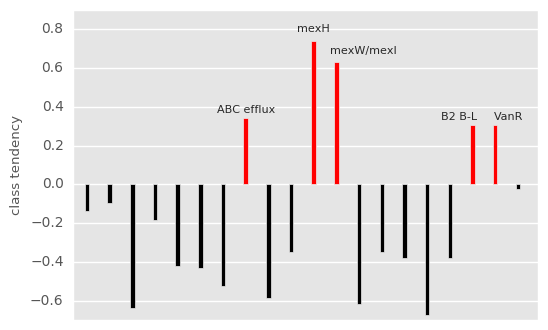

In [824]:
# Determine which genes were the strongest contributors to the principal components used as input to the model
# and were indicative of a genome's tendency to increase after antibiotic administration

def identify_PC_contributors(pca_components, merged_change_res_df):
    """Return the names of the genes or modules that are within the top five contributors of
    at least one of the principal components used as model input."""
    merged_gene_df = merged_change_res_df.drop(0, axis=1)
    PC_RF_corr = pd.DataFrame(pca_components, columns=merged_gene_df.columns) # convert PCs to dataframe
    PC_RF_corr_abs = PC_RF_corr.abs() # convert to absolute value to determine PC strongest contributors
    PC_to_top_five = {} # dictionary containing each PC (key) to its top five components (values)
    PC_num = 1
    for x in range(0,5):
        selected_PC = PC_RF_corr_abs.ix[x:x,:].sort_values(by=x,axis=1)
        top_five = selected_PC.ix[:,-5:] 
        PC_to_top_five[PC_num] = top_five
        PC_num += 1
    five_pc_df = pd.concat(PC_to_top_five.values()) # generate dataframe from the component dictionary
    return(five_pc_df.columns) # return the names of the strongest contributors
    
def calculate_class_tendency(merged_change_res_df, accessions_of_interest):
    """Of the genes that are the strongest contributors to the principal components,
    return the genes that are associated with the 'increase' class of genomes and return
    a value that represents their tendency to occur in this classs"""
    increase_df = merged_change_res_df.loc[merged_change_res_df[0]=='increase']
    decrease_df = merged_change_res_df.loc[merged_change_res_df[0]=='decrease']
    accession_to_group = {}
    accession_to_ratio = {}
    accessions = []
    ratios = []
    # label whether a particular gene or module more frequently appeared in the 'increase' or 'decrease' group
    for accession in accessions_of_interest:
        if increase_df[accession].mean() > decrease_df[accession].mean():
            group = 'increase'
        else:
            group = 'decrease'
        accession_to_group[accession] = group
        ratio = increase_df[accession].mean()/decrease_df[accession].mean() #calculate ratio of means
        accession_to_ratio[accession] = ratio
        accessions.append(accession)
        ratios.append(ratio)
    return(np.asarray(ratios))

def autolabel(rects, list_of_labels):
    """Give labels to bars of interest in bar graph."""
    labels = accessions
    i = 0
    for rect in rects:
        if i == 11:
            height = rect.get_height()
            plt.text(rect.get_x() + 1.3, 1.05*height,
            list_of_labels[i], ha='center', va='bottom')
        elif i == 17:
            height = rect.get_height()
            plt.text(rect.get_x() - 0.5, 1.05*height,
            list_of_labels[i], ha='center', va='bottom')
        elif i == 18:
            height = rect.get_height()
            plt.text(rect.get_x() + 0.7, 1.05*height,
            list_of_labels[i], ha='center', va='bottom')
        else:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    list_of_labels[i], ha='center', va='bottom')
        i = i+1
    
merged_change_res_df = merge_resfams_and_kegg(genome_before_after, genome_resistance_gene_summaries, \
                                               KEGG_genome_profiles)
accessions_of_interest = identify_PC_contributors(pca.components_, merged_change_res_df)
class_tendency_data = calculate_class_tendency(merged_change_res_df, accessions_of_interest)

#Plot results
genes_for_bars = []
for accession in accessions:
    genes_for_bars.append(accession_to_gene[accession])
genes_for_bars
l_labels = list(" "*len(genes_for_bars)) # initialize list of empty strings
# label the bars that correspond to the increase class (names  from 'genes for bars' were abbreviated manually)
l_labels[7] = "ABC efflux"
l_labels[10] = 'mexH'
l_labels[11] = 'mexW/mexI'
l_labels[17] = 'B2 B-L'
l_labels[18] = 'VanR'
baseline = 1
mask = class_tendency_data <= 1
colors = np.array(['r']*len(class_tendency_data))
colors[mask] = 'k'
ind = range(len(class_tendency_data))
plt.figure(figsize=(6,4))
bg = plt.bar(ind,[x - baseline for x in class_tendency_data], width=0.2, color=colors)
plt.xlim(-0.5,20)
plt.ylim(-0.7,0.9)
plt.ylabel('class tendency')
plt.gca().xaxis.grid(False)
plt.xticks([])
autolabel(bg, l_labels)
plt.rcParams.update({'font.size': 8})
plt.show()

### Full interpretation of the above analysis is available here: {add paper link when published}